# Mediapipe face mesh

In [1]:
import cv2
import mediapipe as mp
import numpy as np
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

2024-06-10 01:11:44.002071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 01:11:44.087549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 01:11:44.991432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# FUNCTION TO EXTRACT MASK FROM MEDIAPIPE IMAGES



def show_images(df, image_dir, n_images=5, title='None'):
    N = len(df)
    plt.figure(figsize=(15, (N//5 + 1)*3))
    for i in range(N):
        plt.subplot(N//5 + 1, n_images, i + 1)
        img = Image.open(f"{image_dir}/{df.iloc[i]['filename']}")
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
def is_black_and_white(img):
    # check if image has 2 channels
    dim = len(np.array(img).shape)
    
    if dim == 2:
        return True
    # check if image has 3 channels and all channels are equal
    elif dim == 3:
        if ((np.array(img)[:,:,2] == np.array(img)[:,:,1]).all() == True &
            (np.array(img)[:,:,0] == np.array(img)[:,:,1]).all() == True &
            (np.array(img)[:,:,0] == np.array(img)[:,:,2]).all() == True ):
            return True
        else:
            return False
    else:
        return False

def get_points(image, results):
    '''Extracts the skin landmarks (x,y) coordinates detected by MediaPipe Face Mesh from the detected face.
    Length may vary if several faces are detected.
    Input :
    - image : The original image (must be in RGB format)
    - results : The output of the MediaPipe Face Mesh model'''
    # Define indices for the facial landmarks that typically represent the skin area
    skin_landmark_indices = list(range(0, 468))  # Indices for all landmarks
    points = []

    # Extract the skin landmarks from the detected face
    if results.multi_face_landmarks: # Check if any face is detected
        for face_landmarks in results.multi_face_landmarks: # take only first face
            for idx in skin_landmark_indices:
                x = int(face_landmarks.landmark[idx].x * image.shape[1])
                y = int(face_landmarks.landmark[idx].y * image.shape[0])
                points.append([x, y])

    points = np.array(points)
    return points

def get_mask_from_points(image, points):
    '''Returns the mask correponding to the skin area visible. 
    The mask is created by drawing a convex hull around the skin landmarks detected by MediaPipe Face Mesh.
    Input :
    - image : The original image (must be in RGB format) - to get the size of the mask
    - points : The output of the MediaPipe Face Mesh model
    Output : mask (numpy array) corresponding to the skin area (or all image if no face detected) 
    skin area value = 255 (white) and mask value = 0 (black)'''

    # Create a mask for the skin area
    mask = np.zeros_like(image) # default mask is all black (zero values)
    
    if len(points) > 0: # if face is detected
        # Create a convex hull around the skin landmarks to approximate the skin area
        hull = cv2.convexHull(points)
        # Draw the convex hull on the mask
        cv2.fillConvexPoly(mask, hull, (255, 255, 255))

    else: # if no face detected, mask is all white (255 values)
        mask = np.ones_like(image) * 255

    return mask 

def get_masked_image(image, results) :
    '''Returns the mask correponding to the skin area visible. 
    The mask is created by drawing a convex hull around the skin landmarks detected by MediaPipe Face Mesh.
    Input :
    - image : The original image (must be in RGB format)
    - results : The output of the MediaPipe Face Mesh model
    Output : .jpg image with only the skin area visible and rest of the image masked out (balck)'''
    
    # Extract list of skin landmarks from the detected face - (x,y) coordinates only
    points = get_points(image, results)

    # Create a mask for the skin area
    mask = get_mask_from_points(image, points)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, mask)

    return mask, masked_image

def get_mesh(image, results):
    '''Returns the image with the skin landmarks detected by MediaPipe Face Mesh overlayed on it.
    Input :
    - image : The original image (must be in RGB format)
    - points : List containing the 468 (x,y) coordinates of the landmarks obtained with MediaPipe Face Mesh model
    Output : .jpg image with the skin landmarks overlayed on the original image'''

    # Copy the original image
    meshed_image = image.copy()

    # Draw the facial landmarks on the image using tesselation
    if results.multi_face_landmarks:
        for f, face_landmarks in enumerate(results.multi_face_landmarks):
            if f==0:
                # Draw the facial landmarks on the image using tesselation
                mp_drawing.draw_landmarks(
                    image=meshed_image,
                    landmark_list=face_landmarks,  # face_landmarks is a list of landmarks for one face (dictionnary with x, y & z keys)
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                )

    return meshed_image

def get_contours(initial_image, results):
    '''Returns the contour corresponding to the skin area visible. 
    The contour is created by drawing a convex hull around the skin landmarks detected by MediaPipe Face Mesh.
    Input :
    - image : The original image (must be in RGB format) - to get the size of the mask
    - points : The output of the MediaPipe Face Mesh model
    Output : .jpg image with face contours)'''

    # Copy the original image
    contoured_image = initial_image.copy()

    # Draw the facial landmarks on the image using tesselation
    if results.multi_face_landmarks: # ifa face is detected
        for f, face_landmarks in enumerate(results.multi_face_landmarks):
            if f==0:
                # Draw the facial landmarks on the image using tesselation
                mp_drawing.draw_landmarks(
                    image=contoured_image,
                    landmark_list=face_landmarks,  # face_landmarks is a list of landmarks for one face (dictionnary with x, y & z keys)
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                )
        return contoured_image
    else:
        return initial_image

def show_mask(image, meshed_image, mask, masked_image ):
    '''Display the original image, the landmarks, the mask and the masked image side by side'''
    plt.figure(figsize=(12, 3.5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(1, 4, 2)
    plt.imshow(meshed_image)
    plt.title('Landmarks (Mesh or Contours)')
    plt.subplot(1, 4, 3)
    plt.imshow(mask)
    plt.title('Mask')
    plt.subplot(1, 4, 4)
    plt.imshow(masked_image)
    plt.title('Skin Area')
    plt.suptitle('Skin Area Extraction with MediaPipe Face Mesh Model\n'+path)
    plt.show()


In [3]:
# open df_train.pkl

image_dir = "Data/crops_100K"
df_train = pd.read_csv("Data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("Data/listes_training/data_100K/test_students.csv", delimiter=' ')

# drop the rows where FaceOcclusion is empty & add binary gender column
df_train = df_train.dropna(subset=['FaceOcclusion'])
df_train['gender_id'] = np.round(df_train['gender'] ).astype(int)

# reset the index
#df_train = df_train.reset_index(drop=True)
print(df_train.index)
df_train.head(-10)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            101335, 101336, 101337, 101338, 101339, 101340, 101341, 101342,
            101343, 101344],
           dtype='int64', length=101341)


,filename,FaceOcclusion,gender,gender_id
0,database1/img00011271.jpg,0.019,0.999,1
1,database1/img00012471.jpg,0.035,1.000,1
2,database1/img00008127.jpg,0.127,0.001,0
3,database1/img00008972.jpg,0.014,0.999,1
4,database1/img00028187.jpg,0.346,0.982,1
...,...,...,...,...
101330,database3/database3/m.01drbr/59-FaceId-0_align...,0.000,1.000,1
101331,database3/database3/m.01drbr/69-FaceId-0_align...,0.021,0.998,1
101332,database3/database3/m.01drbr/7-FaceId-0_align.jpg,0.008,1.000,1
101333,database3/database3/m.01drbr/71-FaceId-0_align...,0.005,1.000,1


# 1/ Load the model

In [4]:
# Test with the mediapipe face mesh pretrained model
# download the mediapipe library   
# pip install mediapipe

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1717974710.538596   73985 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717974710.562808   74128 gl_context.cc:357] GL version: 3.1 (OpenGL ES 3.1 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: D3D12 (NVIDIA T1000)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717974710.567639   74108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# 2/ Test on a color image and a "grayscale" image

W0000 00:00:1717974710.576643   74111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


/home/anaele/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Data/crops_100K/database1/img00011271.jpg


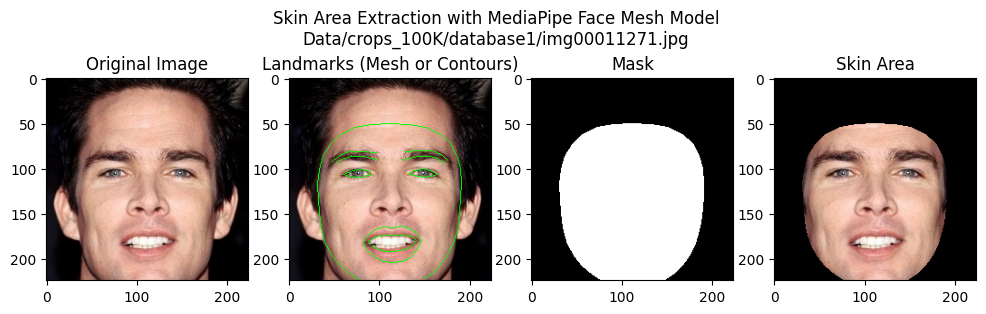

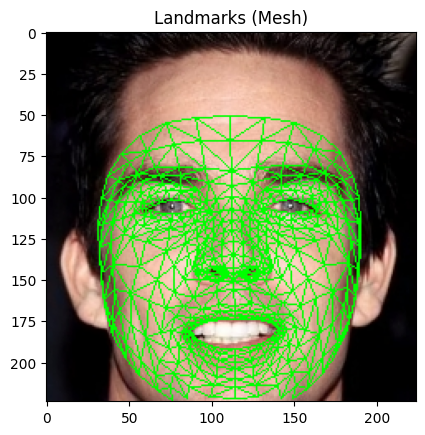

In [5]:
# Load your color image and convert it to RGB
#--------------------------------------------

# Load image
image_dir = "Data/crops_100K"
path = f"{image_dir}/{df_train.loc[0]['filename']}"
print(path)
image = cv2.imread(path)

# convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# apply model
results = face_mesh.process(image)

# get the points and the masked image
mask, skin_area = get_masked_image(image,results)
mesh = get_mesh(image, results)
contours = get_contours(image, results)

# Display the original image and the skin area
show_mask(image, contours, mask, skin_area)

plt.imshow(mesh)
plt.title('Landmarks (Mesh)')
plt.show()

image shape: (224, 224, 3)
mask shape: (224, 224, 3)
masked image shpae: (224, 224, 3)


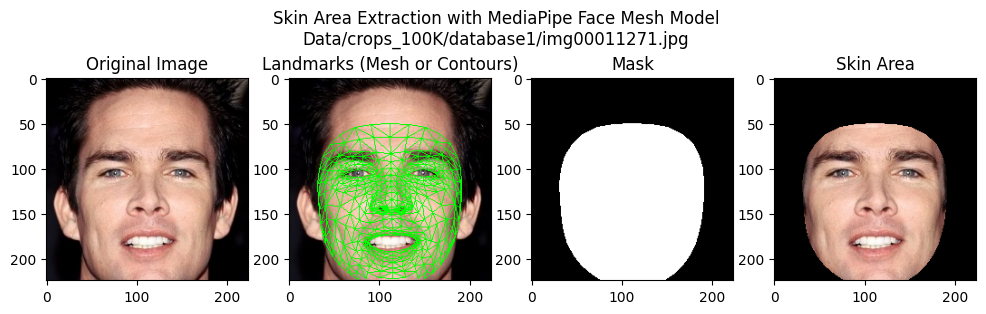

In [6]:
# get_masked_image() is equivalent to 

# get mask with mediapipe
results = face_mesh.process(image)       # Process the image to find face landmarks
points = get_points(image, results)      # Extract list of skin landmarks from the detected face - (x,y) coordinates only
mask = get_mask_from_points(image, points) # Create a mask for the skin area
skin_area = cv2.bitwise_and(image, mask) # Apply the mask to the original image

print('image shape:',image.shape)
print('mask shape:',mask.shape)
print('masked image shpae:',skin_area.shape)

show_mask(image, mesh, mask, skin_area)

image_ shape: (224, 224, 3)
mask_ shape: (224, 224, 3)


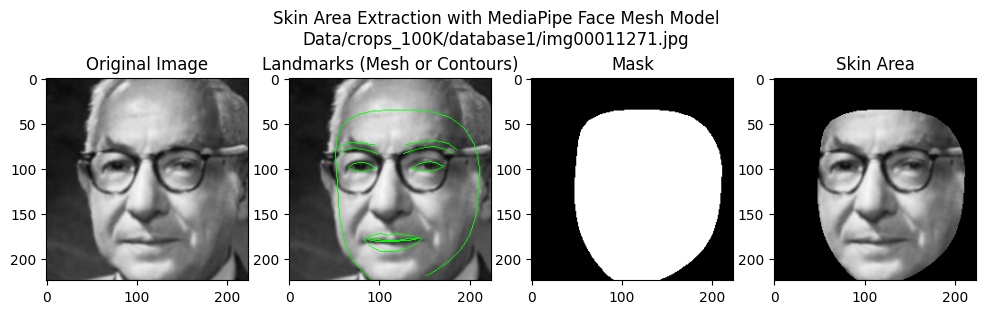

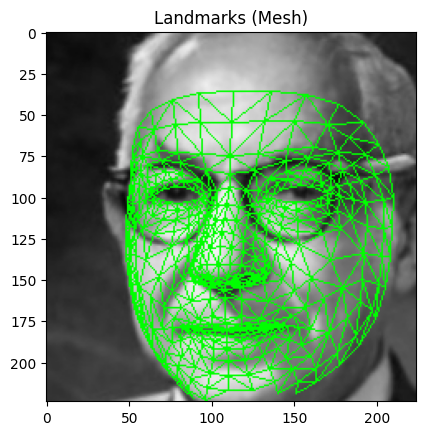

In [7]:
# Load a black and white image (3 channels)
# -----------------------------------------

# !!! Note : image must have 3 channels !)
path_ = "Data/crops_100K/database3/database3/m.01b_6y/40-FaceId-0_align.jpg"
image_ = cv2.imread(path_)
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
print("image_ shape:", image_.shape)

# get mask with mediapipe
results_ = face_mesh.process(image_)       # Process the image to find face landmarks
mask_, skin_area_ = get_masked_image(image_, results_) # Extract the skin landmarks and create a mask
contours_ = get_contours(image_, results_)
mesh_ = get_mesh(image_, results_)

print("mask_ shape:", mask_.shape)
show_mask(image_, contours_, mask_, skin_area_)
plt.imshow(mesh_)
plt.title('Landmarks (Mesh)')
plt.show()

In [8]:
# test with a black and white image (1 channel)
#----------------------------------------------

image_1_channel = image_[:,:,0]

# get mask with mediapipe
print("Extracting mask from a black and white image (1 channel)")
try:
    results = face_mesh.process(image_1_channel)
except:
    print("Error: image must have 3 channels")
    print("image_1 shape:", image_1_channel.shape)

Extracting mask from a black and white image (1 channel)
Error: image must have 3 channels
image_1 shape: (224, 224)


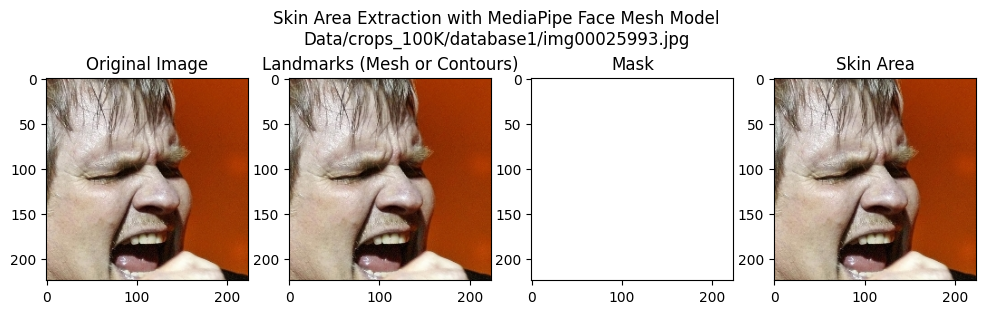

In [9]:
# Image where no face is detected
#--------------------------------

# images stored in 
path = 'Data/crops_100K/database1/img00025993.jpg' # index 488 = 'Data/crops_100K/' + df_train.loc[488]['filename']
image_ = cv2.imread(path)
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

results_ = face_mesh.process(image_)
mask_ , masked_image_ = get_masked_image(image_, results_)
contours_ = get_contours(image_, results_)
show_mask(image_, contours_, mask_, masked_image_)

# 3/ Explore the output of the model

In [10]:
# Explore the results of the MediaPipe Face Mesh model
# ----------------------------------------------------

print("result type:", type(results))
print("result.multi_face_landmarks type:", type(results.multi_face_landmarks), "\n      length:", len(results.multi_face_landmarks))
print("result.multi_face_landmarks[0] type:", type(results.multi_face_landmarks[0]))
print("results.multi_face_landmarks[0].landmark type:", type(results.multi_face_landmarks[0].landmark), "\n      length:", len(results.multi_face_landmarks[0].landmark))
print("result.multi_face_landmarks[0].landmark[0] type:", type(results.multi_face_landmarks[0].landmark[0]))
print("\nlandmark point:\n", results.multi_face_landmarks[0].landmark[0])

result type: <class 'type'>
result.multi_face_landmarks type: <class 'list'> 
      length: 1
result.multi_face_landmarks[0] type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
results.multi_face_landmarks[0].landmark type: <class 'google._upb._message.RepeatedCompositeContainer'> 
      length: 468
result.multi_face_landmarks[0].landmark[0] type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmark'>

landmark point:
 x: 0.510595202
y: 0.741574943
z: -0.116614483



mask type: <class 'numpy.ndarray'>
mask shape: (224, 224, 3)
mask type: <class 'numpy.ndarray'>
mask dtype: uint8
number of pixels in the mask: 50176
number of white pixels in the mask (=face): 23742 (47.32%)
number of black pixels in the mask (=background): 26434 (52.68%)
values in the mask [  0 255]


Text(0.5, 1.0, 'Channel 2 \n(gray colormap)')

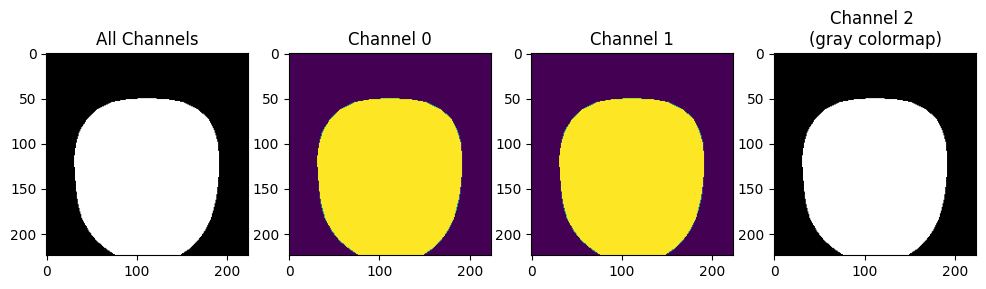

In [11]:
# explore the mask (white = 255 and black = 0)
# ----------------------------------------------

print("mask type:", type(mask))
print("mask shape:", mask.shape)
print("mask type:", type(mask))
print("mask dtype:", mask.dtype)
print("number of pixels in the mask:", mask.shape[0] * mask.shape[1])
print(f"number of white pixels in the mask (=face): {np.sum(mask[:,:,0] == 255)} ({np.sum(mask[:,:,0] == 255) / (mask.shape[0] * mask.shape[1]) * 100:.2f}%)")
print(f"number of black pixels in the mask (=background): {np.sum(mask[:,:,0] == 0)} ({np.sum(mask[:,:,0] == 0) / (mask.shape[0] * mask.shape[1]) * 100:.2f}%)")
print("values in the mask",np.unique(mask))

# Show the mask in different channels
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(mask)
plt.title('All Channels')
plt.subplot(1, 4, 2)
plt.imshow(mask[:,:,0])
plt.title('Channel 0')
plt.subplot(1, 4, 3)
plt.imshow(mask[:,:,1])
plt.title('Channel 1')
plt.subplot(1, 4, 4)
plt.imshow(mask[:,:,2], cmap='gray')
plt.title('Channel 2 \n(gray colormap)') 

# 4/ Process all images
=> masked images stored in a new directory "masked_images"<br>
=> mediapipe face mesh keypoints (468) stored in a new directory "mesh_keypoints"

!!! if no face is detected, the original image is stored in the "masked_images" "contoured image" and "meshed_images" directories

In [12]:
########################################################
# PREPROCESSING DES IMAGES TEST ET DATAFRAME TEST
# (circa 1 hour with GPU)
########################################################

train_preprocess = False # set to True to process all the images
img_dir = "Data/crops_100K"

if train_preprocess == True:

    #initialisation
    df_train['db_number'] = df_train['filename'].apply(lambda x: (x.split('/')[0])[-1])
    df_train['db_number'] = df_train['db_number'].astype(int)
    df_train['black_and_white']=0 # 0 = color 1 = black & white
    df_train['image_width'] = 0
    df_train['image_height'] = 0
    df_train['channels'] = 0
    df_train['pixels'] = 0
    df_train['face'] = 1   # 1 = 1 face detected, 0 = no face detected
    df_train['face_pixels'] = 0
    df_train['mask_pixels'] = 0
    df_train['count'] = 1
    train_no_face_indices = []

    for i in df_train.index:
        if i == 100: print(i)
        if i == 1000: print(i)
        if i % 5000 == 0: print(i)

        # load image; convert and save information
        image = cv2.imread(f"{image_dir}/{df_train.loc[i]['filename']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if is_black_and_white(image):
            df_train.loc[i, 'black_and_white'] = 1
        df_train.loc[i, 'image_width'] = image.shape[0]
        df_train.loc[i, 'image_height'] = image.shape[1]
        df_train.loc[i, 'pixels'] = image.shape[0] * image.shape[1]
        df_train.loc[i, 'channels'] = image.shape[2]

        # process image
        results = face_mesh.process(image)
        mask, skin_area = get_masked_image(image, results)
        contours = get_contours(image, results)
        mesh = get_mesh(image, results)
        cv2.imwrite('Data/Mediapipe/masked_images/' + str(i) + '_masked.jpg', cv2.cvtColor(skin_area, cv2.COLOR_RGB2BGR))
        cv2.imwrite('Data/Mediapipe/contoured_images/' + str(i) + '_mesh.jpg', cv2.cvtColor(contours, cv2.COLOR_RGB2BGR))
        cv2.imwrite('Data/Mediapipe/meshed_images/' + str(i) + '_contour.jpg', cv2.cvtColor(mesh, cv2.COLOR_RGB2BGR))
        
        # save mask info in df and landmarks  (if any) to a file
        if results.multi_face_landmarks: #face detected

            # save mask information
            df_train.loc[i, 'face_pixels'] = mask[:,:,0].sum() / 255 # white pixels only ( value = 255) on 1 channel only
            df_train.loc[i, 'mask_pixels'] = df_train.loc[i, 'pixels'] - df_train.loc[i, 'face_pixels']

            # save landmarks to file
            for f, face_landmarks in enumerate(results.multi_face_landmarks):
                if f==0:
                    landmarks_list = face_landmarks
                    with open('Data/Mediapipe/keypoints/' + str(i) + '_landmarks.pkl', 'wb') as file:
                        pickle.dump(landmarks_list, file)

        else:
            df_train.loc[i, 'face'] = 0
            df_train.loc[i, 'face_pixels'] = df_train.loc[i, 'pixels']
            df_train.loc[i, 'mask_pixels'] = 0
            train_no_face_indices.append(i)

    df_train['color']= df_train['black_and_white'].apply(lambda x: 0 if x == True else 1)
    df_train['no_color']= 1 - df_train['color']

    # Save the dataframe and the no_face_indices
    with open('Data/Mediapipe/df_train_.pkl', 'wb') as f: pickle.dump(df_train, f)
    with open('Data/Mediapipe/train_no_face_indices_.pkl', 'wb') as f: pickle.dump(train_no_face_indices, f)

else:
    print("Set train_preprocess to True to process all the images")
    # Load the dataframe and the no_face_indices
    with open('Data/Mediapipe/df_train.pkl', 'rb') as f: df_train = pickle.load(f)
    with open('Data/Mediapipe/train_no_face_indices.pkl', 'rb') as f: no_face_indices_train = pickle.load(f)
    print("df_train and no_face_indices_train are loaded")  

df_train.head(-10)

0


/home/anaele/myenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


100
1000
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


,filename,FaceOcclusion,gender,gender_id,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color
0,database1/img00011271.jpg,0.019,0.999,1,1,0,224,224,3,50176,1,23742,26434,1,1,0
1,database1/img00012471.jpg,0.035,1.000,1,1,0,224,224,3,50176,1,24922,25254,1,1,0
2,database1/img00008127.jpg,0.127,0.001,0,1,0,224,224,3,50176,1,25174,25002,1,1,0
3,database1/img00008972.jpg,0.014,0.999,1,1,0,224,224,3,50176,1,24241,25935,1,1,0
4,database1/img00028187.jpg,0.346,0.982,1,1,0,224,224,3,50176,1,24248,25928,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101330,database3/database3/m.01drbr/59-FaceId-0_align...,0.000,1.000,1,3,0,224,224,3,50176,1,22324,27852,1,1,0
101331,database3/database3/m.01drbr/69-FaceId-0_align...,0.021,0.998,1,3,1,224,224,3,50176,1,22694,27482,1,0,1
101332,database3/database3/m.01drbr/7-FaceId-0_align.jpg,0.008,1.000,1,3,1,224,224,3,50176,1,23888,26288,1,0,1
101333,database3/database3/m.01drbr/71-FaceId-0_align...,0.005,1.000,1,3,0,224,224,3,50176,1,22711,27465,1,1,0


In [15]:
print(df_train.columns)
df_train.describe()

Index(['filename', 'FaceOcclusion', 'gender', 'gender_id', 'db_number',
       'black_and_white', 'image_width', 'image_height', 'channels', 'pixels',
       'face', 'face_pixels', 'mask_pixels', 'count', 'color', 'no_color'],
      dtype='object')


,FaceOcclusion,gender,gender_id,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color
count,101341.000000,101341.000000,101341.000000,101341.000000,101341.000000,101341.0,101341.0,101341.0,101341.0,101341.000000,101341.000000,101341.000000,101341.0,101341.000000,101341.000000
mean,0.087769,0.599738,0.601080,2.394668,0.138888,224.0,224.0,3.0,50176.0,0.985633,25115.498327,25060.501673,1.0,0.861112,0.138888
std,0.090530,0.486110,0.489679,0.911578,0.345831,0.0,0.0,0.0,0.0,0.119000,3407.442517,3407.442517,0.0,0.345831,0.345831
min,0.000000,0.000000,0.000000,1.000000,0.000000,224.0,224.0,3.0,50176.0,0.000000,1081.000000,0.000000,1.0,0.000000,0.000000
25%,0.019000,0.001000,0.000000,1.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,23859.000000,24369.000000,1.0,1.000000,0.000000
50%,0.054000,0.996000,1.000000,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,24834.000000,25342.000000,1.0,1.000000,0.000000
75%,0.131000,0.999000,1.000000,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,25807.000000,26317.000000,1.0,1.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,1.000000,224.0,224.0,3.0,50176.0,1.000000,50176.000000,49095.000000,1.0,1.000000,1.000000


# Reload Data

In [21]:
# df_train
with open('Data/Mediapipe/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

df_train.head(-10)

,filename,FaceOcclusion,gender,gender_id,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color
0,database1/img00011271.jpg,0.019,0.999,1,1,0,224,224,3,50176,1,23742,26434,1,1,0
1,database1/img00012471.jpg,0.035,1.000,1,1,0,224,224,3,50176,1,24922,25254,1,1,0
2,database1/img00008127.jpg,0.127,0.001,0,1,0,224,224,3,50176,1,25174,25002,1,1,0
3,database1/img00008972.jpg,0.014,0.999,1,1,0,224,224,3,50176,1,24241,25935,1,1,0
4,database1/img00028187.jpg,0.346,0.982,1,1,0,224,224,3,50176,1,24248,25928,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101330,database3/database3/m.01drbr/59-FaceId-0_align...,0.000,1.000,1,3,0,224,224,3,50176,1,22324,27852,1,1,0
101331,database3/database3/m.01drbr/69-FaceId-0_align...,0.021,0.998,1,3,1,224,224,3,50176,1,22694,27482,1,0,1
101332,database3/database3/m.01drbr/7-FaceId-0_align.jpg,0.008,1.000,1,3,1,224,224,3,50176,1,23888,26288,1,0,1
101333,database3/database3/m.01drbr/71-FaceId-0_align...,0.005,1.000,1,3,0,224,224,3,50176,1,22711,27465,1,1,0


In [23]:
# open face landmarks (keypoints) file
n=0
landmarks_path = 'Data/Mediapipe/keypoints/'+str(n)+'_landmarks.pkl'
print(landmarks_path)
with open(landmarks_path, 'rb') as f:
    landmarks_list = pickle.load(f)
print('number fo landmarks',len(landmarks_list.landmark))



Data/Mediapipe/keypoints/0_landmarks.pkl
number fo landmarks 468


# 5/ Load the masked images for the test set


In [ ]:
df_test = pd.read_csv('Data/listes_training/data_100K/test_students.csv')
df_test = df_test.dropna()
df_test.head(-5)

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg
...,...
30497,database3/database3/m.01507p/8-FaceId-0_align.jpg
30498,database3/database3/m.01507p/80-FaceId-0_align...
30499,database3/database3/m.01507p/81-FaceId-0_align...
30500,database3/database3/m.01507p/82-FaceId-0_align...


In [26]:
########################################################
# PREPROCESSING DES IMAGES TEST ET DATAFRAME TEST
########################################################

test_preprocess = False # set to True to process all the images
img_dir = "Data/crops_100K"

if test_preprocess == True:
    #initialisation
    df_test['db_number'] = df_test['filename'].apply(lambda x: (x.split('/')[0])[-1])
    df_test['db_number'] = df_test['db_number'].astype(int)
    df_test['black_and_white']=0 # 0 = color 1 = black & white
    df_test['image_width'] = 0
    df_test['image_height'] = 0
    df_test['channels'] = 0
    df_test['pixels'] = 0
    df_test['face'] = 1   # 1 = 1 face detected, 0 = no face detected
    df_test['face_pixels'] = 0
    df_test['mask_pixels'] = 0
    df_test['count'] = 1
    test_no_face_indices = []

    for i in df_test.index:
        if i % 5000 == 0: print(i)

        # load image; convert and save information
        image = cv2.imread(f"{image_dir}/{df_test.loc[i]['filename']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if is_black_and_white(image):
            df_test.loc[i, 'black_and_white'] = 1
        df_test.loc[i, 'image_width'] = image.shape[0]
        df_test.loc[i, 'image_height'] = image.shape[1]
        df_test.loc[i, 'pixels'] = image.shape[0] * image.shape[1]
        df_test.loc[i, 'channels'] = image.shape[2]

        # process image
        results = face_mesh.process(image)
        mask, skin_area = get_masked_image(image, results)
        contours = get_contours(image, results)
        mesh = get_mesh(image, results)
        cv2.imwrite('Data/Mediapipe/masked_images_test/' + str(i) + '_masked.jpg', cv2.cvtColor(skin_area, cv2.COLOR_RGB2BGR))
        cv2.imwrite('Data/Mediapipe/contoured_images_test/' + str(i) + '_mesh.jpg', cv2.cvtColor(contours, cv2.COLOR_RGB2BGR))
        cv2.imwrite('Data/Mediapipe/meshed_images_test/' + str(i) + '_contour.jpg', cv2.cvtColor(mesh, cv2.COLOR_RGB2BGR))
        
        # save mask information to df and landmarks (if any) to a file
        if results.multi_face_landmarks: #face detected

            # save mask information
            df_test.loc[i, 'face_pixels'] = mask[:,:,0].sum() / 255 # white pixels only ( value = 255) on 1 channel only
            df_test.loc[i, 'mask_pixels'] = df_test.loc[i, 'pixels'] - df_test.loc[i, 'face_pixels']

            # save landmarks to file
            for f, face_landmarks in enumerate(results.multi_face_landmarks):
                if f==0:
                    landmarks_list = face_landmarks
                    with open('Data/Mediapipe/keypoints_test/' + str(i) + '_landmarks.pkl', 'wb') as file:
                        pickle.dump(landmarks_list, file)
        else:
            df_test.loc[i, 'face'] = 0
            df_test.loc[i, 'face_pixels'] = df_test.loc[i, 'pixels']
            df_test.loc[i, 'mask_pixels'] = 0
            test_no_face_indices.append(i)

    df_test['color']= df_test['black_and_white'].apply(lambda x: 0 if x == True else 1)
    df_test['no_color']= 1 - df_test['color']
    # Save the dataframe and the no_face_indices
    with open('Data/Mediapipe/df_test_.pkl', 'wb') as f: pickle.dump(df_test, f)
    with open('Data/Mediapipe/test_no_face_indices.pkl', 'wb') as f: pickle.dump(test_no_face_indices, f)

else :
    print('Images already processed.\nSet test_preprocess to "True" to process all the images')   
    # Load the dataframe and the no_face_indices
    with open('Data/Mediapipe/df_test.pkl', 'rb') as f: df_test = pickle.load(f)
    with open('Data/Mediapipe/test_no_face_indices.pkl', 'rb') as f:
        no_face_indices_test = pickle.load(f)
    print("df_test and no_face_indices_test are loaded")  

0
5000
10000
15000
20000
25000
30000


In [27]:
df_test.head(-5)

,filename,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color
0,database2/database2/test/0.jpg,2,0,224,224,3,50176,1,23769,26407,1,1,0
1,database2/database2/test/1.jpg,2,0,224,224,3,50176,1,22645,27531,1,1,0
2,database2/database2/test/2.jpg,2,1,224,224,3,50176,1,21595,28581,1,0,1
3,database2/database2/test/3.jpg,2,0,224,224,3,50176,1,25282,24894,1,1,0
4,database2/database2/test/4.jpg,2,0,224,224,3,50176,1,23271,26905,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30497,database3/database3/m.01507p/8-FaceId-0_align.jpg,3,0,224,224,3,50176,1,24796,25380,1,1,0
30498,database3/database3/m.01507p/80-FaceId-0_align...,3,0,224,224,3,50176,1,23872,26304,1,1,0
30499,database3/database3/m.01507p/81-FaceId-0_align...,3,0,224,224,3,50176,1,25407,24769,1,1,0
30500,database3/database3/m.01507p/82-FaceId-0_align...,3,0,224,224,3,50176,1,25153,25023,1,1,0


In [28]:
df_test.describe()

,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color
count,30507.000000,30507.000000,30507.0,30507.0,30507.0,30507.0,30507.000000,30507.000000,30507.000000,30507.0,30507.000000,30507.000000
mean,2.983381,0.192775,224.0,224.0,3.0,50176.0,0.978726,25070.855935,25105.144065,1.0,0.807225,0.192775
std,0.127842,0.394485,0.0,0.0,0.0,0.0,0.144298,4041.550540,4041.550540,0.0,0.394485,0.394485
min,2.000000,0.000000,224.0,224.0,3.0,50176.0,0.000000,2008.000000,0.000000,1.0,0.000000,0.000000
25%,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,23639.000000,24530.000000,1.0,1.000000,0.000000
50%,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,24648.000000,25528.000000,1.0,1.000000,0.000000
75%,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,25646.000000,26537.000000,1.0,1.000000,0.000000
max,3.000000,1.000000,224.0,224.0,3.0,50176.0,1.000000,50176.000000,48168.000000,1.0,1.000000,1.000000


In [29]:

stats_test = df_test.groupby('db_number')['count','color','no_color'].sum()
stats_test.loc['total'] = stats_test.sum()
stats_test['no_color_%'] = stats_test['no_color'] / stats_test['count'] * 100
stats_test

/tmp/ipykernel_73985/1436226840.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_test = df_test.groupby('db_number')['count','color','no_color'].sum()


,count,color,no_color,no_color_%
db_number,,,,
2,507,475,32,6.311637
3,30000,24151,5849,19.496667
total,30507,24626,5881,19.277543


# 5/ TRAIN TEST SPLIT

## !!! SPLIT IN STARTER NOTEBOOK NOT BALANCED AMONG DATABASES AND COLOR /BALCK AND WHITE IMAGES !!!

In [30]:

df_train.describe()
# with open('Data/Mediapipe/df_train.pkl', 'wb') as f: pickle.dump(df_train, f)

,FaceOcclusion,gender,gender_id,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color
count,101341.000000,101341.000000,101341.000000,101341.000000,101341.000000,101341.0,101341.0,101341.0,101341.0,101341.000000,101341.000000,101341.000000,101341.0,101341.000000,101341.000000
mean,0.087769,0.599738,0.601080,2.394668,0.138888,224.0,224.0,3.0,50176.0,0.985633,25115.498327,25060.501673,1.0,0.861112,0.138888
std,0.090530,0.486110,0.489679,0.911578,0.345831,0.0,0.0,0.0,0.0,0.119000,3407.442517,3407.442517,0.0,0.345831,0.345831
min,0.000000,0.000000,0.000000,1.000000,0.000000,224.0,224.0,3.0,50176.0,0.000000,1081.000000,0.000000,1.0,0.000000,0.000000
25%,0.019000,0.001000,0.000000,1.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,23859.000000,24369.000000,1.0,1.000000,0.000000
50%,0.054000,0.996000,1.000000,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,24834.000000,25342.000000,1.0,1.000000,0.000000
75%,0.131000,0.999000,1.000000,3.000000,0.000000,224.0,224.0,3.0,50176.0,1.000000,25807.000000,26317.000000,1.0,1.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,1.000000,224.0,224.0,3.0,50176.0,1.000000,50176.000000,49095.000000,1.0,1.000000,1.000000


In [31]:
stats_train = df_train.groupby('db_number')['count','color','no_color'].sum()
stats_train.loc['total'] = stats_train.sum()
# add column with percentage of no color images
stats_train['no_color_%'] = stats_train['no_color'] / stats_train['count'] * 100
stats_train

/tmp/ipykernel_73985/2957510624.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_train = df_train.groupby('db_number')['count','color','no_color'].sum()


,count,color,no_color,no_color_%
db_number,,,,
1,30000,30000,0,0.000000
2,1345,1234,111,8.252788
3,69996,56032,13964,19.949711
total,101341,87266,14075,13.888752


In [32]:
# train after split df_train[20000:]
#-----------------------------------
stats_20000_plus = df_train[20000:].groupby('db_number')['count','color','no_color'].sum()
# add a row with sum of each columns
stats_20000_plus.loc['total'] = stats_20000_plus.sum()

# add column with percentage of black and white images
stats_20000_plus['no_color_%'] = stats_20000_plus['no_color'] / stats_20000_plus['count'] * 100
stats_20000_plus

/tmp/ipykernel_73985/3411787477.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_20000_plus = df_train[20000:].groupby('db_number')['count','color','no_color'].sum()


,count,color,no_color,no_color_%
db_number,,,,
1,10000,10000,0,0.000000
2,1345,1234,111,8.252788
3,69996,56032,13964,19.949711
total,81341,67266,14075,17.303697


In [33]:
# validaton set after split df_train[:20000]
stats_20000_less = df_train[20000:].groupby('db_number')['count','color','no_color'].sum()
stats_20000_less['no_color_%'] = stats_20000_less['no_color'] / stats_20000_less['count'] * 100

/tmp/ipykernel_73985/1859599720.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_20000_less = df_train[20000:].groupby('db_number')['count','color','no_color'].sum()


## Solution : stratified Train_test_split() on synthetic variable
Creation of a "stratification label" with database, gender and color<br>
for example :<br>
 - 2 0 1 = 2nd database + female + color image<br>
 - 1 1 0 = 1st database + male + grayscale image

In [34]:
# Stratification labels format : db_number + gender_id + color

import numpy as np
from sklearn.model_selection import train_test_split

df_train['stratification'] = 100 * df_train['db_number'] + 10 * df_train['gender_id'] + df_train['color']
df_train[['db_number','gender_id','color','stratification']].head(-5)

# save dataframe
with open('Data/Mediapipe/df_train.pkl', 'wb') as f: pickle.dump(df_train, f)

In [35]:
# Train test split on stratification labels

train, val = train_test_split(df_train, test_size=0.2, stratify=df_train['stratification'], random_state=42)

# check distribution of stratification labels in train and val sets
stat_df = df_train.groupby(['stratification'])['count'].sum()
stat_train = train.groupby(['stratification'])['count'].sum()
stat_val = val.groupby(['stratification'])['count'].sum()
df = pd.concat([stat_df,stat_train, stat_val], axis=1, keys=['all_train', 'train','val'])

# add total row & percentage columns
df.loc['total'] = df.sum()
df['train_%'] = np.round(df['train'] / df['all_train'] * 100,2)
df['val_%'] = np.round(df['val'] / df['all_train'] * 100,2)
df

,all_train,train,val,train_%,val_%
stratification,,,,,
101,19155,15324,3831,80.00,20.00
111,10845,8676,2169,80.00,20.00
200,34,27,7,79.41,20.59
201,594,475,119,79.97,20.03
210,77,62,15,80.52,19.48
211,640,512,128,80.00,20.00
300,4194,3355,839,80.00,20.00
301,16450,13160,3290,80.00,20.00
310,9770,7816,1954,80.00,20.00


In [36]:
# Save train and val dataframes
with open('train.pkl', 'wb') as f: pickle.dump(train, f)
with open('val.pkl', 'wb') as f: pickle.dump(val, f)


In [3]:
# Load train and val dataframes
import pickle
with open('train.pkl', 'rb') as f: train = pickle.load(f)
with open('val.pkl', 'rb') as f: val = pickle.load(f)
train.head(-5)

,filename,FaceOcclusion,gender,gender_id,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color,stratification
98934,database3/database3/m.01dffd/1-FaceId-0_align.jpg,0.030,0.999,1,3,0,224,224,3,50176,1,15248,34928,1,1,0,311
2895,database1/img00016049.jpg,0.264,0.001,0,1,0,224,224,3,50176,1,15980,34196,1,1,0,101
51471,database3/database3/m.016mm_/64-FaceId-0_align...,0.007,0.999,1,3,0,224,224,3,50176,1,14942,35234,1,1,0,311
33063,database3/database3/m.0153y1/85-FaceId-0_align...,0.081,0.001,0,3,0,224,224,3,50176,1,16630,33546,1,1,0,301
38749,database3/database3/m.015l51/82-FaceId-0_align...,0.036,0.993,1,3,0,224,224,3,50176,1,15577,34599,1,1,0,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82951,database3/database3/m.01b8gp/1-FaceId-0_align.jpg,0.021,0.999,1,3,0,224,224,3,50176,1,17088,33088,1,1,0,311
62012,database3/database3/m.017rpy/4-FaceId-0_align.jpg,0.213,1.000,1,3,0,224,224,3,50176,1,15522,34654,1,1,0,311
26759,database1/img00010378.jpg,0.192,0.000,0,1,0,224,224,3,50176,1,17134,33042,1,1,0,101
42966,database3/database3/m.015x4b/9-FaceId-0_align.jpg,0.000,0.997,1,3,0,224,224,3,50176,1,14888,35288,1,1,0,311


In [5]:
# Load train and val dataframes
import pickle
with open('df_train.pkl', 'rb') as f: df_train = pickle.load(f)
with open('df_test.pkl', 'rb') as f: df_test = pickle.load(f)
df_train.head(-5)

,filename,FaceOcclusion,gender,gender_id,db_number,black_and_white,image_width,image_height,channels,pixels,face,face_pixels,mask_pixels,count,color,no_color,stratification
0,database1/img00011271.jpg,0.019,0.999,1,1,0,224,224,3,50176,1,23742,26434,1,1,0,111
1,database1/img00012471.jpg,0.035,1.000,1,1,0,224,224,3,50176,1,24922,25254,1,1,0,111
2,database1/img00008127.jpg,0.127,0.001,0,1,0,224,224,3,50176,1,25174,25002,1,1,0,101
3,database1/img00008972.jpg,0.014,0.999,1,1,0,224,224,3,50176,1,24241,25935,1,1,0,111
4,database1/img00028187.jpg,0.346,0.982,1,1,0,224,224,3,50176,1,24248,25928,1,1,0,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101335,database3/database3/m.01drbr/73-FaceId-0_align...,0.290,0.999,1,3,1,224,224,3,50176,1,21759,28417,1,0,1,310
101336,database3/database3/m.01drbr/76-FaceId-0_align...,0.005,1.000,1,3,0,224,224,3,50176,1,22842,27334,1,1,0,311
101337,database3/database3/m.01drbr/79-FaceId-0_align...,0.105,1.000,1,3,0,224,224,3,50176,1,23734,26442,1,1,0,311
101338,database3/database3/m.01drbr/80-FaceId-0_align...,0.241,0.999,1,3,1,224,224,3,50176,1,22908,27268,1,0,1,310


# END